<a href="https://colab.research.google.com/github/pmags/bigData_ML_pipeline/blob/main/BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project structure

1. Introduction

    1.2 Differences to deal with higher volune of data
    
    1.3 Architecture used in this project

    1.4 Environment setup

2. Ingest data

3. Transform data

4. Explore

5. Model

6. Conclusions

# Explore and Modeling on a context of high volume of data

## Introduction

This project explores how cloud infrastructure and different analytical tools can be used to explore and model high volume data.

For this, a dataset of events of patients satys on ICU will be used. Due to its size (compressed 4.2g) it is not feasible to do this analysis using local resources.

The following information is available to us beforehand:

- There are 2 datasets. One which will called events, contains records of events for each visit and patient (one patient can have more than one admission). The second dataset contains data regarding the visit including time of entry and exit.

- We have no information about each event contained on the dataset and neither their nature.

- No information regarding the nature of each dataset column was provided, therefore, we will have to infer during data exploration.

At the end of this project we expect on getting the following output:

1. Ingestion pipelines which can be resused
2. A data architecture which allows further data exploration
3. Basic understanding of the events available
4. Evolution by patient of certain events along the time of stay
5. Model to predict length of stay based on availabe information


## Differences to deal with higher volume of data


## Data Architecture

Part of the challenge is to organize information in a way easy to explore. Having no prior information regarding the datasets available we start by exploring a small sample so we have a better understanding of its schema. 

We will then ingest data into a paralelized datawharehouse solutions (this case bigquery) and organize data as RAW, CLEAN and CURATED. This is also known as a Delta Architecture and is an approach popularized by Spark/Databricks.

Advantages of this approach for our project:

- Heavier transformations are made once,
- Exploration based on smaller tables only containing relevant information,
- Increase readbility and speed,
- Simple structure to maintain,
- Cheaper. On a context of "pay per query" the bigger tables are seldon used.

Apach Beam with Dataflow runner will be used for data ingestion. Once in bigquery, we will use its paralization query capacities to make the necessary transformations (ELT approach). 

For modeling, we will use both bigquery algorithms and sklearn multiprocess acording to our needs. All analysis will be done using **Colab** in order to allow for GPU calculations if required.

> We will assume that data will be dealt in batch, therefore, we don't consider how a stream architecture would look like.

> Throughout this project we will over engineer some processes in order to explore different approaches. For example, given that the datasets are already available in google storage its would acctually cheaper (and probably faster) to use BigQuery load api instead of relying on Dataflow.


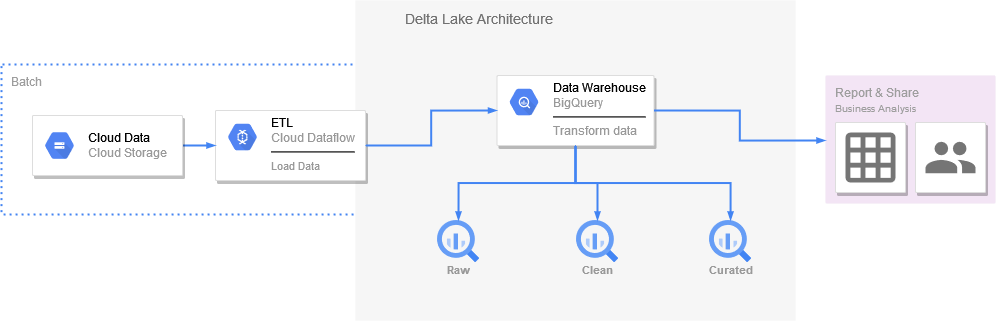

## Environment Setup

In [13]:
### 
# Define environment to run notebook
#
# Install additional libraries
# Import libraries
# Initialize google account and project
###

# Install libraries
#!pip install cachetools --upgrade 
!pip install -q google-cloud-secret-manager # Connects to google secret management for 
!pip install -q apache-beam
!pip install -q apache-beam[gcp]
#!pip install -q 'fsspec>=0.3.3'
#!pip install -q aiohttp
#!pip install -q gcsfs


In [14]:
# Call necessary methods and libraries
import logging
import os
import pandas as pd
import numpy as np

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

from google.colab import auth
#from google.cloud import secretmanager # To be called when secret is needed
from google.cloud import storage
from google.cloud.bigquery.schema import SchemaField
from google.cloud import bigquery

# Request Google account access 
auth.authenticate_user()

# Declare main project variables
PROJECT_ID = "fcup-bigdata"
DATASET_BUCKET = "icu_events_bigdata"
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID


---
# Data Ingestion

Since we have no information regarding each dataset structure, we will start by exploring a smaller sample. This will allow for answering the following questions which are relevant during the ingestion process:

- Data types for each column,
- Each column nature,
- Natural keys which can be leverage during analysis,
- Facts and dimensions.

> **Note:** this samples will be uploaded into the bucket to be used during development to reduce cost. 

> **Note 2:** Due to 403 excpetion on the original dataset (although publicly available), the dataset endup being moved between buckets using Google GUI. The following command line should have worked between 2 buckets

```
!wget https://storage.googleapis.com/big_events/EVENTS.csv.gz -O - | gsutil cp - gs://icu_events_bigdata/icu_events.csv.gz

```

## Explore sample data

In [23]:
# Reading a smaller partition to understand data schema
df_top = pd.read_csv("gs://icu_events_bigdata/icu_events.csv.gz", compression="gzip", nrows = 5000)

# first 5 rows
print(df_top.head())

   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID            CHARTTIME  \
0     788          36   165660      241249  223834  2134-05-12 12:00:00   
1     789          36   165660      241249  223835  2134-05-12 12:00:00   
2     790          36   165660      241249  224328  2134-05-12 12:00:00   
3     791          36   165660      241249  224329  2134-05-12 12:00:00   
4     792          36   165660      241249  224330  2134-05-12 12:00:00   

             STORETIME   CGID   VALUE  VALUENUM VALUEUOM  WARNING  ERROR  \
0  2134-05-12 13:56:00  17525   15.00     15.00    L/min        0      0   
1  2134-05-12 13:56:00  17525  100.00    100.00      NaN        0      0   
2  2134-05-12 12:18:00  20823    0.37      0.37      NaN        0      0   
3  2134-05-12 12:19:00  20823    6.00      6.00      min        0      0   
4  2134-05-12 12:19:00  20823    2.50      2.50      NaN        0      0   

   RESULTSTATUS  STOPPED  
0           NaN      NaN  
1           NaN      NaN  
2          

In [24]:
df_top.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CGID,VALUE,VALUENUM,WARNING,ERROR,RESULTSTATUS,STOPPED
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.0,0.0
mean,2510.065200,76.506800,152693.223200,255840.72140,221682.54640,17960.086400,85.062130,85.062130,0.090600,0.002400,NaN,NaN
std,1459.905145,35.827027,19488.061302,17090.27149,2354.86202,2345.976765,151.718345,151.718345,0.287068,0.048936,NaN,NaN
min,1.000000,23.000000,112077.000000,234044.00000,220045.00000,14411.000000,-11.000000,-11.000000,0.000000,0.000000,NaN,NaN
25%,1250.750000,36.000000,144319.000000,241249.00000,220179.00000,15696.000000,22.000000,22.000000,0.000000,0.000000,NaN,NaN
50%,2500.500000,107.000000,147469.000000,253139.00000,220210.00000,17525.000000,83.000000,83.000000,0.000000,0.000000,NaN,NaN
75%,3750.250000,109.000000,165660.000000,264253.00000,223769.00000,20290.000000,100.000000,100.000000,0.000000,0.000000,NaN,NaN
max,5478.000000,109.000000,182383.000000,291697.00000,227566.00000,21367.000000,3000.000000,3000.000000,1.000000,1.000000,NaN,NaN


In [25]:
# Reading a smaller partition to understand data schema
df_stays_top = pd.read_csv("gs://icu_events_bigdata/ICUSTAYS.csv.gz", compression="gzip", nrows = 5000)

# first 5 rows
print(df_stays_top.head())

   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-

In [26]:
df_stays_top.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4999.000000
mean,2524.620000,1994.960200,149999.812200,249845.363600,34.326400,34.055800,5.826846
std,1488.089827,1186.024618,28999.209945,28663.903135,19.339211,19.313138,11.626504
min,1.000000,2.000000,100009.000000,200066.000000,7.000000,7.000000,0.004400
25%,1250.750000,965.750000,124634.000000,225560.500000,14.000000,14.000000,1.083900
50%,2500.500000,1985.000000,149954.500000,249747.500000,33.000000,33.000000,2.234700
75%,3750.250000,2984.000000,175231.000000,274169.000000,56.000000,56.000000,5.173250
max,5708.000000,4512.000000,199955.000000,299987.000000,57.000000,57.000000,150.799300


From this small sample we can conclude the following regarding the information we are working with:

1. Events dataset is composed of the following columns which seem to have the following nature:

    - **ROW_ID:** unique sequencial number representing an index for data entry. As no value for analysis.

    - **SUBJECT_ID:** Factor variable representing a unique patient. Should be stored as STRING.

    - **HADM_ID:** Factor variable representing admition ID. A patient has one id but can have multiple admition id. Should be stored as STRING.

    - **ICUSTAY_ID:** Factor variable representing a stay at UCI. From the sample data we cannot find a destinction in nature between this id and the admission id. It might happen that this is already part of a larger dataset including other admissions which do not include only UCI. We will keep the data and explore inside big query. Should be stored as STRING.

    - **ITEMID:** Event type ID. Each entry is classified as a code item for which we have no information about its nature. Should be store as STRING.

    - **CGID:** Given the nature of the dataset we assume this represents de Id code for the Emergency Technician who register the information. We have no further information about this data. Should be stored as STRING.

    - **VALUE:** Event item imput value. It could be numeric or a string and can have different units of measure. Given its hybrid nature should be store as STRING.

    - **VALUENUM:** Value if numeric. Should be store as FLOAT.

    - **WARNING:** We have no further information about this values, but it seems to only be related to certain events. We will assume that it represents if a given value input triggered a warning or not. Should be stored as BOOLEAN

    - **ERROR:** We have no further information about this values, but it seems to only be related to certain events. We will assume that it represents if a given value input triggered an error or not. Should be stored as BOOLEAN

    - **RESULTSTATUS:** Categorical value. Should be stored as STRING.

    - **STOPPED:** Categorical value for which we have no information. Should be 
stored as STRING.

2. Stays datasets has the following information:

    - **ROW_ID:** unique sequencial number representing an index for data entry. As no value for analysis.
    
    - **SUBJECT_ID:** Factor variable representing a unique patient. Should be stored as STRING.

    - **HADM_ID:**  Factor variable representing admition ID. A patient has one id but can have multiple admition id. Should be stored as STRING.

    - **ICUSTAY_ID:** Factor variable representing a stay at UCI. From the sample data we cannot find a destinction in nature between this id and the admission id. It might happen that this is already part of a larger dataset including other admissions which do not include only UCI. We will keep the data and explore inside big query. Should be stored as STRING.

    - **DBSOURCE** 

    - **FIRST_CAREUNIT**
    
    - **LAST_CAREUNIT**  
    
    - **FIRST_WARDID**  
    
    - **LAST_WARDID**               
    
    - **INTIME**
    
    - **OUTTIME**     
    
    - **LOS**

3. Based on this sample we conclude that the dataset includes a series of ocurrences/events registerd, probably on some form of software, for which we have the logs. Each row represents something like a measurement, a patient personal entry, a visit appointement or doctor comments. Although they are presented on a time sequence there is no evidence that any correlation exist between them since each entry can have unique natures. We have no information about the nature of each imput. Therefore, we will make some assumptions during our analysis to study the evolution of each patient during his staying.

4. The dataset has a long format, meaning that each event represents a new row. Some analysis might require that we moldel the data into a wider format.

5. Based on this brief initial analysis, the following can be said about the data schema:
    - There are two main focus of analysis, **visits** and **events** inside visits. Given its nature, we can consider then to be each a fact table.
    - The dimensions of analysis are **patient**, **time** and **event category**. Since we have no aditional information regarding each of this dimensions they will be treated as degenerated dimensions (except for time).

Considering that we will upload this into bigquery, in order to make our analysis more efficient we will use a nested schema like the following:

```
"schema": {
    "fields": [
    {
        "SUBJECT_ID": ,
        "HADM_ID": ,
        "ICUSTAY_ID": ",
        "items":[{
            "ITEMID": ,
            "CHARTTIME": ,
            "STORETIME": ,
            "CGID": ,
            "VALUE": ,
            "VALUENUM": ,
            "WARNING": ,
            "ERROR": ,
            "RESULTSTATUS": "",
            "STOPPED": ""
        }],
        "FIRST_CAREUNIT",
        "FIRST_WARDID", 
        "LAST_CAREUNIT", 
        "LAST_WARDID",
        "INTIME",
        "OUTTIME",
        "LOS",
    }
```


In [ ]:
# Upload sample data into bucket
client_storage = storage.Client()
bucket = client_storage.get_bucket(DATASET_BUCKET)  
bucket.blob('icu_events_sample.csv').upload_from_string(df_top.to_csv(index=False), 'text/csv')


## Load data into BigQuery


### Advantages of big query

- We could have used other tools
- We could have stored as other form the data including with diferent files
- But big query takes care of that for us

In [ ]:
# Using bigquery api

def load_into_bq_api(in_test_mode=True):
    ## Creating Dataset ------------------------------------------------------------
    bq = bigquery.Client()
    PROJECT = "fcup-bigdata"
    dataset_id = "{}.uci_events_dataset".format(PROJECT_ID)
    dataset = bq.create_dataset(dataset_id, exists_ok=True)

    # Use schema as variable to create new tables-----------------------------------
    if in_test_mode:
        new_table_id = "{0}.{1}.{2}".format(PROJECT_ID,"uci_events_dataset", "events-sampling")
    else:
        new_table_id = "{0}.{1}.{2}".format(PROJECT_ID,"uci_events_dataset", "events-staging")
    
    print(new_table_id)
    job_config = bigquery.LoadJobConfig(
        autodetect = False,
        schema=[
            bigquery.SchemaField("ROW_ID", "STRING"),
            bigquery.SchemaField("SUBJECT_ID", "STRING"),
            bigquery.SchemaField('HADM_ID', "STRING"),
            bigquery.SchemaField('ICUSTAY_ID', "STRING"),
            bigquery.SchemaField('ITEMID', "STRING"),
            bigquery.SchemaField('CHARTTIME',"DATETIME"),
            bigquery.SchemaField('STORETIME',"DATETIME"),
            bigquery.SchemaField('CGID',"STRING"),
            bigquery.SchemaField('VALUE',"STRING"),
            bigquery.SchemaField('VALUENUM',"FLOAT64"),
            bigquery.SchemaField('VALUEUOM',"STRING"),
            bigquery.SchemaField('WARNING',"STRING"),
            bigquery.SchemaField('ERROR',"STRING"),
            bigquery.SchemaField('RESULTSTATUS',"STRING"),
            bigquery.SchemaField('STOPPED', "STRING")
    ],
        source_format=bigquery.SourceFormat.CSV,
        skip_leading_rows = 1,
        create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED,
        write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
    )

    if in_test_mode:
        uri = "gs://icu_events_bigdata/icu_events_sample.csv"
    else:
        uri = "gs://icu_events_bigdata/icu_events.csv.gz"


    load_job = bq.load_table_from_uri(
        uri,
        new_table_id,
        location = "US",  
        job_config = job_config,
    )  

    load_job.result()

    # Confirm load -----------------------------------------------------------------
    destination_table = bq.get_table(new_table_id)
    print("Loaded {} rows.".format(destination_table.num_rows))

load_into_bq_api(in_test_mode=True)

fcup-bigdata.uci_events_dataset.events-staging
Loaded 330712483 rows.


In [ ]:
# Using Apache beam

dataset_gs = "gs://icu_events_bigdata/icu_events.csv.gz"

# Define several transformations
def parse_csv(line):
  COLNAMES = ['ROW_ID','SUBJECT_ID','HADM_ID','ICUSTAY_ID','ITEMID','CHARTTIME','STORETIME','CGID','VALUE','VALUENUM',
 'VALUEUOM','WARNING','ERROR','RESULTSTATUS','STOPPED']
  try:
    values = line.split(',')
    rowdict = {}
    for colname, value in zip(COLNAMES, values):
      rowdict[colname] = value
    yield rowdict
  except:
    logging.warn('Ignoring line with {} values; expected {}')

def convert_fields(rowdict):
    for dicts in [rowdict]:
        for keys in dicts:
            if keys == 'VALUENUM':
                dicts[keys] = float(dicts[keys])
    yield rowdict


def get_output_schema():
    result = 'VALUENUM:FLOAT64'
    for col in 'ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED'.split(','):
        result = result + ',' + col + ':String'
    print(result)
    return result

def load_into_bq(infile_pattern, bqdataset='testing_dataset', bqtable='events-sampling', in_test_mode=True):
  import shutil, os, subprocess
  import datetime, os
  job_name = 'loadcsv' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  
  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './csv_load'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/csv_load'.format(DATASET_BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass
      
  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT_ID,
      'region': "us-central1",
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
  }
  
  opts = PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  
  with beam.Pipeline(RUNNER, options = opts) as p:
    (p 
        | 'read' >> beam.io.ReadFromText(infile_pattern, skip_header_lines=1)
        | 'parse_csv' >> beam.FlatMap(parse_csv)
        | 'pull_fields' >> beam.FlatMap(convert_fields)
        | 'write_bq' >> beam.io.gcp.bigquery.WriteToBigQuery(bqtable, bqdataset, schema=get_output_schema(), write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
    create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,  custom_gcs_temp_location =  'gs://{0}/csv_load'.format(DATASET_BUCKET))
    )

load_into_bq('gs://icu_events_bigdata/icu_events_sample.csv', in_test_mode = False)

Launching Dataflow job loadcsv-220628-061524 ... hang on


/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:2201: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  self.table_reference.projectId = pcoll.pipeline.options.view_as(
/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery_file_loads.py:1129: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = p.options.view_as(GoogleCloudOptions).temp_location


VALUENUM:FLOAT64,ROW_ID:String,SUBJECT_ID:String,HADM_ID:String,ICUSTAY_ID:String,ITEMID:String,CHARTTIME:String,STORETIME:String,CGID:String,VALUE:String,VALUEUOM:String,WARNING:String,ERROR:String,RESULTSTATUS:String,STOPPED:String


In [ ]:
# Load visists information
from google.cloud.bigquery.schema import SchemaField
from google.cloud import bigquery
import os

bq = bigquery.Client()
PROJECT = "fcup-bigdata"
dataset_id = "{}.uci_events_dataset".format(PROJECT_ID)

# Use schema as variable to create new tables-----------------------------------
new_table_id = "{0}.{1}.{2}".format(PROJECT_ID,"uci_events_dataset", "visits-staging")
print(new_table_id)
job_config = bigquery.LoadJobConfig(
    autodetect = False,
    schema=[
        bigquery.SchemaField("ROW_ID", "STRING"),
        bigquery.SchemaField("SUBJECT_ID", "STRING"),
        bigquery.SchemaField("HADM_ID", "STRING"),
        bigquery.SchemaField("ICUSTAY_ID", "STRING"),
        bigquery.SchemaField("DBSOURCE", "STRING"),
        bigquery.SchemaField("FIRST_CAREUNIT","STRING"),
        bigquery.SchemaField("LAST_CAREUNIT","STRING"),
        bigquery.SchemaField("FIRST_WARDID","STRING"),
        bigquery.SchemaField("LAST_WARDID","STRING"),
        bigquery.SchemaField("INTIME","DATETIME"),
        bigquery.SchemaField("OUTTIME","DATETIME"),
        bigquery.SchemaField("LOS","FLOAT64")
   ],
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows = 1,
    create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED,
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)
uri = "gs://icu_events_bigdata/ICUSTAYS.csv.gz"

load_job = bq.load_table_from_uri(
    uri,
    new_table_id,
    location = "US",  
    job_config = job_config,
)  

load_job.result()

# Confirm load -----------------------------------------------------------------
destination_table = bq.get_table(new_table_id)
print("Loaded {} rows.".format(destination_table.num_rows))


fcup-bigdata.uci_events_dataset.visits-staging
Loaded 61532 rows.


# Transform Data and EDA

In [ ]:
%%bigquery

WITH users AS (
  SELECT DISTINCT SUBJECT_ID, HADM_ID, ICUSTAY_ID 
  FROM `fcup-bigdata.testing_dataset.classes_3`
),
items AS(
  SELECT SUBJECT_ID, HADM_ID, ITEMID, CHARTTIME, STORETIME, CGID, VALUE, VALUENUM, WARNING, ERROR, RESULTSTATUS, STOPPED 
  FROM `fcup-bigdata.testing_dataset.classes_3`
)
SELECT 
  SUBJECT_ID
  , HADM_ID
  , ICUSTAY_ID 
  , ARRAY_AGG(
    STRUCT(ITEMID, CHARTTIME, STORETIME, CGID, VALUE, VALUENUM, WARNING, ERROR, RESULTSTATUS, STOPPED )
    ) AS items
  , FIRST_CAREUNIT
  , FIRST_WARDID
  , LAST_CAREUNIT
  , LAST_WARDID
  , INTIME
  , OUTTIME
  , LOS
  , ROUND(DATETIME_DIFF(OUTTIME, INTIME, MINUTE)/(60*24) ,5)
  , DBSOURCE
FROM users 
LEFT JOIN items USING(SUBJECT_ID,HADM_ID)
INNER JOIN `fcup-bigdata.uci_events_dataset.visits-staging` AS visits
USING(SUBJECT_ID,HADM_ID, ICUSTAY_ID)
GROUP BY SUBJECT_ID
  , HADM_ID
  , ICUSTAY_ID
  , FIRST_CAREUNIT
  , FIRST_WARDID
  , LAST_CAREUNIT
  , LAST_WARDID
  , INTIME
  , OUTTIME
  , LOS
  , DBSOURCE ; 


-----

# Explore Patient and Stay data

# Model stay duration